# Code for Ice-Cube 3D CNN
Using Wahid's tutorial keras code on ICE-Cube CNN data.
- October 5, 2018: 2D CNN works.
- October 6, 2018: got simple 3D CNN to work.

In [1]:
from nbfinder import NotebookFinder
import sys
import os
sys.meta_path.append(NotebookFinder())
from load_data import get_data

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib notebook
%matplotlib widget

import numpy as np
import glob

importing Jupyter notebook from load_data.ipynb
importing Jupyter notebook from util.ipynb


Useful blog for keras conv3D: http://learnandshare645.blogspot.com/2016/06/3d-cnn-in-keras-action-recognition.html

In [2]:
ls

ROC_plot.py   load_data.ipynb  my_code.ipynb  nbfinder.pyc       rpv_weights.h5
__pycache__/  main.ipynb       nbfinder.py    resnet_util.ipynb  util.ipynb


In [3]:

# keras modules
import keras
from keras import layers, models, optimizers, callbacks  # or tensorflow.keras as keras
import tensorflow as tf

# from keras.layers import *
# from keras.models import Model,Sequential
# from keras.optimizers import adam


Using TensorFlow backend.


In [5]:
# Import modules form other nbs
from resnet_util import identity_block,conv_block

importing Jupyter notebook from resnet_util.ipynb


In [28]:
# import sys; sys.executable
# print(keras.__version__)

### Extracting data

In [7]:
sigpath = "/project/projectdirs/dasrepo/icecube_data/hdf5_out/filtered/nugen/11374/clsim-base-4.0.3.0.99_eff/"
sig_list=glob.glob(sigpath+'*00.hdf5')
bgpath = "/project/projectdirs/dasrepo/icecube_data/hdf5_out/filtered/corsika/11057/"
bg_list=glob.glob(bgpath+'*00.hdf5')

inx,iny = get_data(sig_list, bg_list)

In [8]:
print(inx.shape)
print(iny.shape)
print(inx[0,0,:,0],iny[5])

(1388, 60, 10, 20)
(1388,)
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 1.0)


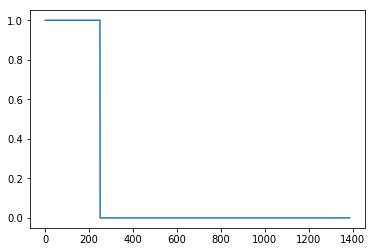

In [9]:
plt.figure()
plt.plot(iny[:])
plt.show()

In [10]:
print(inx.shape[0])

1388


### Create training and cross-validation inputs

In [11]:
inx2=np.expand_dims(inx,axis=1)
inx3=np.transpose(inx2,axes=[0,3,4,2,1])
print(inx2.shape,inx3.shape)

inpx=inx3.copy()
inpy=iny.copy()

num=(inpx.shape[0])
cval_prop=0.5
cv_index=int(cval_prop*num)
train_x,train_y=inpx[:cv_index],inpy[:cv_index]
cval_x,cval_y=inpx[cv_index:],inpy[cv_index:]

print(train_x.shape,train_y.shape)
print(cval_x.shape,cval_y.shape)

((1388, 1, 60, 10, 20), (1388, 10, 20, 60, 1))
((694, 10, 20, 60, 1), (694,))
((694, 10, 20, 60, 1), (694,))


### Testing Conv2D 

In [12]:
# # making a 2D conv array for testing purposes
# inx4=inx3[:,[2,3,4]]
# inx4=inx3[:,0,:,:,:]
# print(inx4.shape)
# iny.shape

In [13]:
# inputs = layers.Input(shape=inx4.shape[1:])
# h = inputs

# # Convolutional layers
# conv_sizes=[64, 128, 256]
# conv_args = dict(kernel_size=(3, 3), activation='relu', padding='same')
# for conv_size in conv_sizes:
#     h = layers.Conv2D(conv_size, **conv_args)(h)
#     h = layers.MaxPooling2D(pool_size=(2, 2))(h)
# #h = layers.Dropout(0.5)(h)
# h = layers.Flatten()(h)

# # Fully connected  layers
# h = layers.Dense(64, activation='relu')(h)
# #    h = layers.Dropout(0.5)(h)

# # Ouptut layer
# outputs = layers.Dense(1, activation='sigmoid')(h)


# model = models.Model(inputs, outputs)
# model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

## Notes:
- model.fit 
    - batch_size= sample of data used for training (subset of full training set). 
    - epoch= number of runs over training data
    - callbacks=
    
- for layers.Input need size (x,y,z,1) in channels_last mode.

In [14]:
# model.fit(x=inx4, y=iny,
#                       batch_size=128,
#                       epochs=3,
#                       verbose=1,
#                       callbacks = [
#                         callbacks.ModelCheckpoint('./rpv_weights.h5')
#                       ],                      
#                 )

In [15]:
# model.summary()

### Conv3D


To figure out:
- model.fit(callbacks= ...)
- model.predict 


### Test 1

In [16]:
inputs = layers.Input(shape=train_x.shape[1:])
h = inputs

# Convolutional layers
conv_sizes=[64, 128, 256]
conv_args = dict(kernel_size=(3, 3, 3), activation='relu', padding='same')
for conv_size in conv_sizes:
    h = layers.Conv3D(conv_size, **conv_args)(h)
    h = layers.MaxPooling3D(pool_size=(2, 2, 2))(h)
#h = layers.Dropout(0.5)(h)
h = layers.Flatten()(h)

# Fully connected  layers
h = layers.Dense(64, activation='relu')(h)
#    h = layers.Dropout(0.5)(h)

# Ouptut layer
outputs = layers.Dense(1, activation='sigmoid')(h)

In [17]:
model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_x, y=train_y,
                      batch_size=32,
                      epochs=3,
                      verbose=1,
                      callbacks = [
                        callbacks.ModelCheckpoint('./rpv_weights.h5')
                      ],                      
                )

Epoch 1/3
694/694 [==============================] - 124s 178ms/step - loss: 5.7071 - acc: 0.6225
Epoch 2/3
694/694 [==============================] - 101s 146ms/step - loss: 5.8062 - acc: 0.6398
Epoch 3/3
694/694 [==============================] - 60s 87ms/step - loss: 5.8062 - acc: 0.6398


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 20, 60, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 20, 60, 64)    1792      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 10, 30, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 10, 30, 128)    221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 5, 15, 128)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 5, 15, 256)     884992    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 1, 2, 7, 256)      0         
__________

In [20]:
score = model.evaluate(cval_x,  cval_y); print ("Validation Accuracy: " + str(score[1] ))

694/694 [==============================] - 55s 79ms/step
Validation Accuracy: 1.0


In [29]:
score = model.evaluate(train_x,  train_y); print ("Test Accuracy: " + str(score[1] ))

694/694 [==============================] - 29s 42ms/step
Test Accuracy: 0.6397694524495677


In [22]:
print(score)
prd=model.predict(cval_x,verbose=1)
# print(prd)

[1.0000001515422036e-07, 1.0]
694/694 [==============================] - 54s 78ms/step


In [23]:
type(prd),prd.shape

(numpy.ndarray, (694, 1))

In [24]:
prd.shape,prd[prd>0.0].shape

((694, 1), (0,))

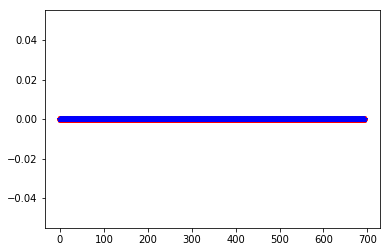

In [25]:
# Plotting cv results

plt.figure()
plt.plot(cval_y,color='r',marker='H')
plt.plot(prd,color='b',linestyle='',marker='*')
plt.show()

### Test 2

In [26]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_base_init',
 '_built',
 '_check_trainable_weights_consistency',
 '_collected_trainable_weights',
 '_compute_previous_mask',
 '_expects_training_arg',
 '_feed_input_names',
 '_feed_input_shapes',
 '_feed_inputs',
 '_feed_loss_fns',
 '_feed_output_names',
 '_feed_output_shapes',
 '_feed_outputs',
 '_feed_sample_weight_modes',
 '_feed_sample_weights',
 '_feed_targets',
 '_function_kwargs',
 '_get_node_attribute_at_index',
 '_inbound_nodes',
 '_init_graph_network',
 '_init_subclassed_network',
 '_initial_weights',
 '_input_coordinates',
 '_input_layers',
 '_is_compiled',
 '_is_graph_network',
 '_layers',
 '_layers_by_depth',
 '_losses',
 '_make_predict_f

### Old code from Zahra

In [27]:
# plt.figure()
# plt.plot(history.history['loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.show()

# # plt.savefig('lossresnetgpu3.png')

#### notes:
- shuffle data
- weighted rock curve (curve in the plot).
- Result on Monday!